In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

In [2]:
def load_and_invert(image_path, threshold_val = 127):
    img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    if img is None: 
        raise ValueError("Image not found or unable to load")
    
    _,binary = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # stick with OTSU thresholding instead of Savuola for computational sake. 

    binary_complement = cv2.bitwise_not(binary)
    return binary_complement

def detect_lines(img, canny_low=50, canny_high=150, hough_thresh=100, min_line_len=100, max_line_gap=10):
    edges = cv2.Canny(img, canny_low, canny_high, apertureSize=3)
    lines_p = cv2.HoughLinesP(edges, 1, np.pi/180, hough_thresh, minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines_p

def compute_angle_degrees(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    angle_rad = math.atan2(dy, dx)  # angle in radians w.r.t x-axis
    angle_deg = np.degrees(angle_rad)
    return angle_deg

def filter_and_aggregate_angles(lines, angle_tolerance=20, vertical=False):
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle_deg = compute_angle_degrees(x1, y1, x2, y2)
        
        if angle_deg > 180:
            angle_deg -= 360
        elif angle_deg <= -180:
            angle_deg += 360

        if vertical:
            # near ±90
            if abs(abs(angle_deg) - 90) < angle_tolerance:
                angles.append(angle_deg)
        else:
            angle_mod_180 = abs(angle_deg) % 180
            if (angle_mod_180 < angle_tolerance) or \
               ((180 - angle_mod_180) < angle_tolerance):
                angles.append(angle_deg)
    
    if len(angles) == 0:
        return 0.0
    
    median_angle = np.median(angles)
    
    if not vertical:
        # shift angles near ±180 to near 0
        if median_angle > 90:
            median_angle -= 180
        elif median_angle < -90:
            median_angle += 180
    
    return median_angle

def rotate_image(img, angle_deg):
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    
    M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)
    # For ECG, setting a white border is often better for "blank" area
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_NEAREST,
                             borderValue=(255,255,255))
    return rotated

def correct_orientation(image_path, vertical=False):
    img_inv = load_and_invert(image_path, threshold_val=90)
    
    lines_p = detect_lines(img_inv,
                           canny_low=50,
                           canny_high=200,
                           hough_thresh=120,
                           min_line_len=80,
                           max_line_gap=20)
    
    if lines_p is None:
        print("No lines detected.")
        return img_inv
    
    median_angle = filter_and_aggregate_angles(lines_p, angle_tolerance=15,
                                               vertical=vertical)
    print(f"Median angle for rotation: {median_angle:.2f} deg")
    
    rotated = rotate_image(img_inv, median_angle) 
    return rotated

Median angle for rotation: -1.08 deg


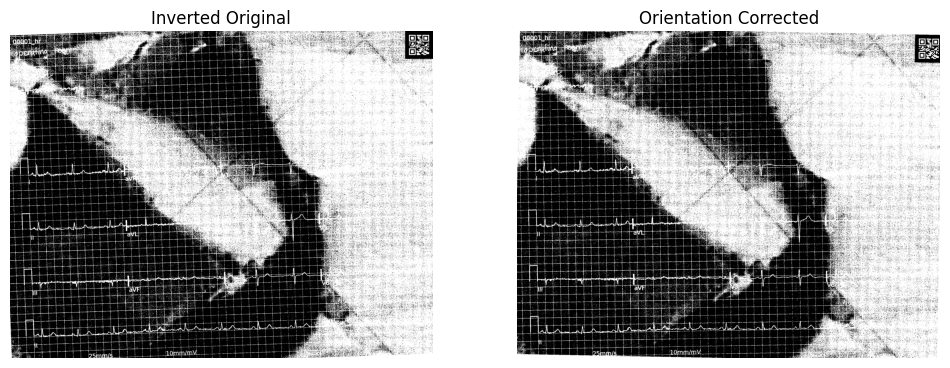

In [13]:
# test on messier data
input_path = "D:/distorted_dat_rec_500/00000_distorted/00001_hr-0.png" 
corrected = correct_orientation(input_path, vertical=False)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Inverted Original")    
plt.imshow(load_and_invert(input_path), cmap='gray')    
plt.axis('off')

plt.subplot(1,2,2)   
plt.title("Orientation Corrected")
plt.imshow(corrected, cmap='gray')
plt.axis('off')
plt.show()

# binarization is insufficient. 

In [3]:
def sauvola_binarize(gray_img, window=15, k=0.2, r=128):
    img = gray_img.astype(np.float64)

    h, w = img.shape
    b = cv2.integral(img)      
    c = cv2.integral(img**2)   

    bin_img = np.zeros_like(img, dtype=np.uint8)
    half_win = window // 2

    for y in range(h):
        for x in range(w):
            
            y1 = max(0, y - half_win)
            y2 = min(h - 1, y + half_win)
            x1 = max(0, x - half_win)
            x2 = min(w - 1, x + half_win)

            region_height = (y2 - y1 + 1)
            region_width  = (x2 - x1 + 1)
            region_size   = region_height * region_width

            sum_region = b[y2+1, x2+1] - b[y2+1, x1] - b[y1, x2+1] + b[y1, x1]
            sum_sq_region = c[y2+1, x2+1] - c[y2+1, x1] - c[y1, x2+1] + c[y1, x1]

            m = sum_region / region_size

            var = (sum_sq_region / region_size) - (m * m)

            std_dev = math.sqrt(var) if var > 0 else 0


            T = m * (1 + k * ((std_dev / r) - 1))


            if img[y, x] < T:
                bin_img[y, x] = 0
            else:
                bin_img[y, x] = 255

    bin_img[:half_win, :] = 255
    bin_img[:, :half_win] = 255
    bin_img[h-half_win:, :] = 255
    bin_img[:, w-half_win:] = 255

    binary_complement = cv2.bitwise_not(bin_img)

    return binary_complement

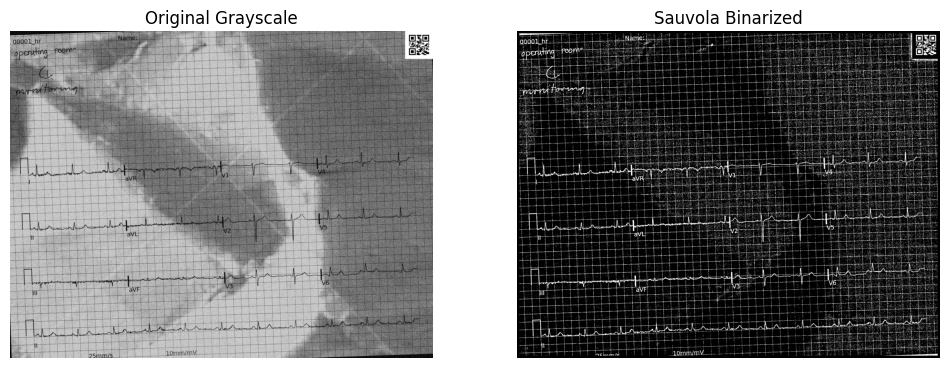

In [15]:
gray_image = cv2.imread("D:/distorted_dat_rec_500/00000_distorted/00001_hr-0.png", cv2.IMREAD_GRAYSCALE)

bin_img = sauvola_binarize(gray_image, window=25, k=0.3, r=128)

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Original Grayscale")
plt.imshow(gray_image, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Sauvola Binarized")
plt.imshow(bin_img, cmap='gray')
plt.axis('off')
plt.show()



In [4]:
def correct_orientation2(image_path, vertical=False): # adjust for savuola binarization
    img_grey = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_inv = sauvola_binarize(img_grey,window=25, k=0.3, r=128)
    
    lines_p = detect_lines(img_inv,
                           canny_low=50,
                           canny_high=200,
                           hough_thresh=120,
                           min_line_len=80,
                           max_line_gap=20)
    
    if lines_p is None:
        print("No lines detected.")
        return img_inv
    
    median_angle = filter_and_aggregate_angles(lines_p, angle_tolerance=15,
                                               vertical=vertical)
    print(f"Median angle for rotation: {median_angle:.2f} deg")
    
    rotated = rotate_image(img_inv, median_angle) 
    return rotated

Median angle for rotation: -1.99 deg


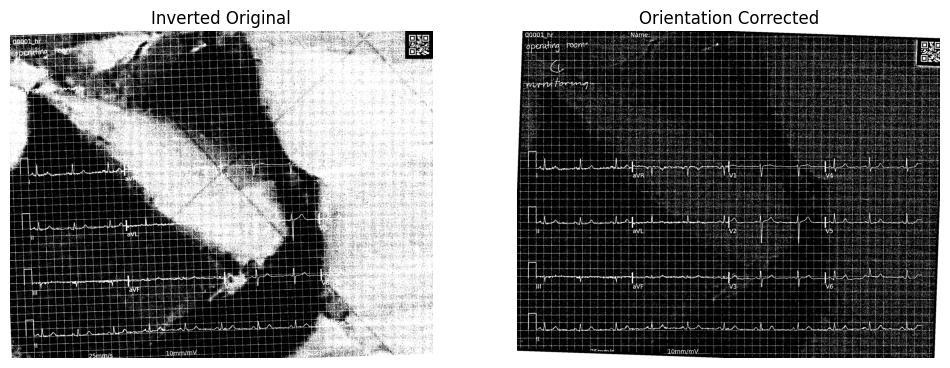

In [17]:
input_path = "D:/distorted_dat_rec_500/00000_distorted/00001_hr-0.png"
corrected = correct_orientation2(input_path, vertical=False)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Inverted Original")    
plt.imshow(load_and_invert(input_path), cmap='gray')    
plt.axis('off')

plt.subplot(1,2,2)   
plt.title("Orientation Corrected")
plt.imshow(corrected, cmap='gray')
plt.axis('off')
plt.show()


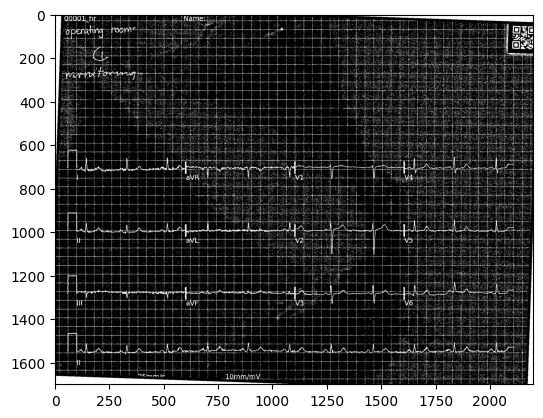

In [18]:
plt.imshow(corrected, cmap = 'gray')

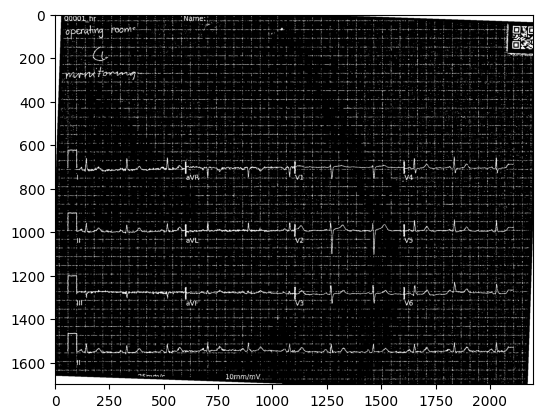

In [19]:
kernel = np.ones((3, 3), dtype=np.float32) * (1/9)

# Apply convolution using the kernel
convolved_image = cv2.filter2D(corrected, -1, kernel)

binary1_mask = (convolved_image > 125)

binary2 = binary1_mask * corrected

plt.imshow(binary2, cmap='gray')


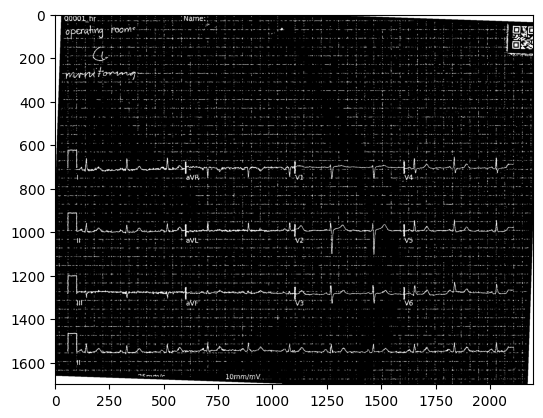

In [20]:
convolved_image = cv2.filter2D(binary2, -1, kernel)

binary2_mask = (convolved_image > 125)

binary3 = binary2_mask * binary2

plt.imshow(binary3, cmap='gray')


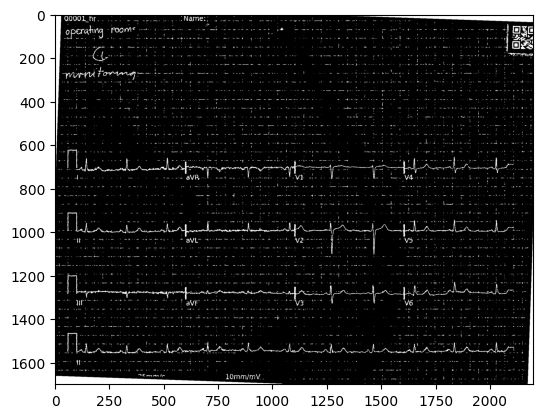

In [21]:
convolved_image = cv2.filter2D(binary3, -1, kernel)

binary3_mask = (convolved_image > 125)

binary4 = binary3_mask * binary3

plt.imshow(binary4, cmap='gray')


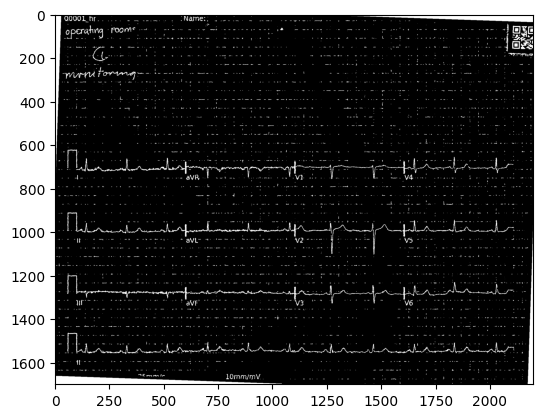

In [22]:
convolved_image = cv2.filter2D(binary4, -1, kernel)

binary4_mask = (convolved_image > 125)

binary5 = binary4_mask * binary4

plt.imshow(binary5, cmap='gray')


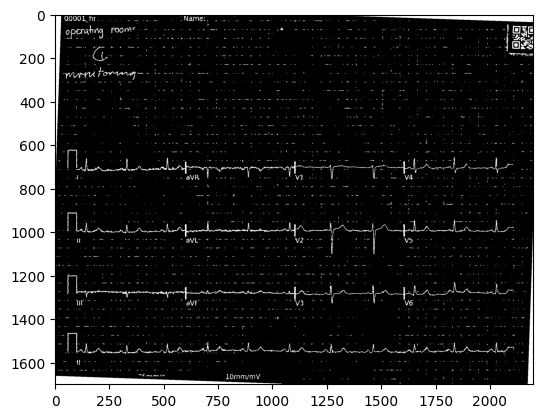

In [23]:
convolved_image = cv2.filter2D(binary5, -1, kernel)

binary5_mask = (convolved_image > 125)

binary6 = binary5_mask * binary5

plt.imshow(binary6, cmap='gray')

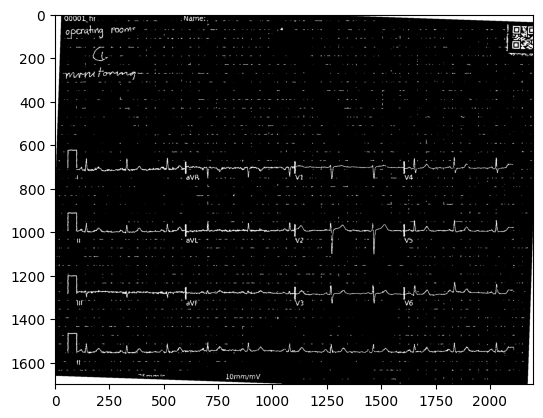

In [24]:
convolved_image = cv2.filter2D(binary6, -1, kernel)

binary6_mask = (convolved_image > 125)

binary7 = binary6_mask * binary6

plt.imshow(binary7, cmap='gray')

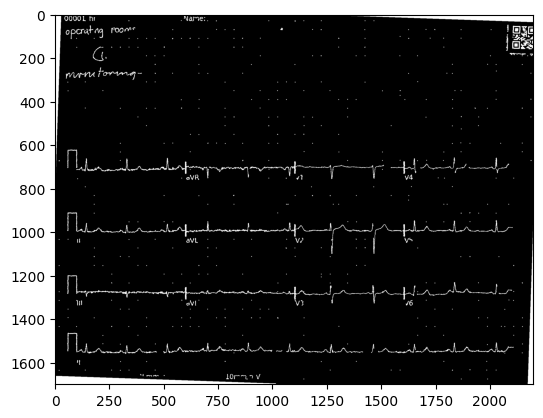

In [25]:
current_image = binary7
next_image = None
for i in range(10000):
    convolved_image = cv2.filter2D(current_image,-1,kernel)
    current_mask = (convolved_image > 125)
    next_image = current_mask* current_image 
    current_image = next_image 

plt.imshow(next_image, cmap='gray')

In [5]:
kernel = np.ones((3, 3), dtype=np.float32) * (1/9)
def grid_removal(img):
    current_image = img
    next_image = None
    for i in range(6):
        convolved_image = cv2.filter2D(current_image,-1,kernel)
        current_mask = (convolved_image > 125)
        next_image = current_mask* current_image 
        current_image = next_image 

    return current_image
    

# *KEY ERROR:* 

The code only works when the image isn't cut. The second png is cut, so it doesn't work well on that. 

## Run the material on a mass scale onto clean versions of the EKG data. 

Steps to take to run. 
#1 Run correct_orientation2() which runs the binarization and the orientation correction


#2 Run the grid_removal 

In [28]:
img_clean_path = "dat/data/00000/00001_lr-0.png"

img_clean_post = grid_removal(correct_orientation2(img_clean_path))

Median angle for rotation: 0.00 deg


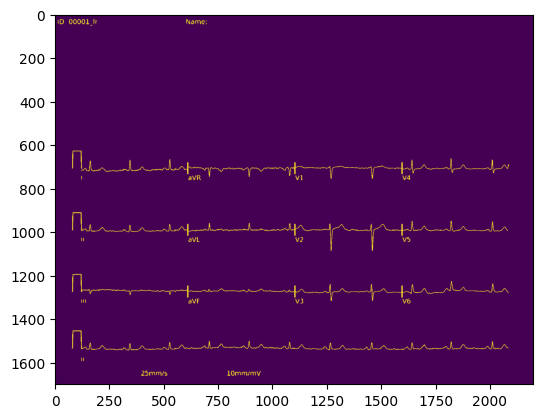

In [25]:
plt.imshow(img_clean_post)

In [6]:
import os
import glob
from PIL import Image

In [7]:
root_dir = "C:/Users/gkim296/ekg/dat/data/06000"
output_root = "C:/Users/gkim296/ekg/dat/connected_binarized/100_06000"

png_files = glob.glob(os.path.join(root_dir,"*.png"),recursive = True)

for img_path in png_files:


    relative_path = os.path.relpath(img_path, root_dir)
    output_path = os.path.join(output_root, relative_path)
    if os.path.exists(output_path):
        # print(f"Skipping {relative_path}, already processed.")
        continue

    gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if gray_img is None:
        print(f"Skipping {img_path}, image could not be loaded.")
        continue


    export_img = grid_removal(correct_orientation2(img_path))

    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, export_img)

Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0.00 deg
Median angle for rotation: 0

KeyboardInterrupt: 

# up to 4:16 pm for uploading to the drive. 